# DSLabs functions

In [106]:
%run "scripts/dslabs_functions.py"


# Data functions

In [107]:
%run "scripts/data_functions.py"

import pandas as pd
import numpy as np



data_functions lodaded


# Load

In [108]:
from pandas import read_csv, DataFrame, Series
import pandas as pd
from functools import reduce
import os
print(os.getcwd())

/Users/cozmaeug/Private/IST PG - DS/DaSH ENG/ist_dash_2024_rec/time_series_forecasting/notebooks/dataset_2_store_sales


In [109]:
train=pd.read_csv(f"dataset/series_scaled_agg_w_train.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)
test=pd.read_csv(f"dataset/series_scaled_agg_w_test.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)

target='sales'
file_tag = "Ecuadorian Store Sales"

trnX = train.drop(columns=[target])
trnY = train[target]
tstX = test.drop(columns=[target])
tstY = test[target]

## Simple Average

## Simple Average evaluate

In [110]:
from sklearn.base import RegressorMixin


class SimpleAvgRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean: float = 0.0
        return

    def fit(self, X: Series):
        self.mean = X.mean()
        return

    def predict(self, X: Series) -> Series:
        prd: list = len(X) * [self.mean]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

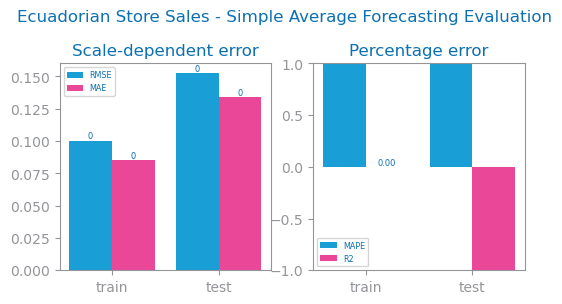

In [111]:
import pandas as pd

# Fit the Model
model = SimpleAvgRegressor()
model.fit(pd.Series(trnY))

# Predict the training and testing data
prd_trn = pd.Series(model.predict(pd.Series(trnY)), index=train.index)
prd_tst = pd.Series(model.predict(pd.Series(tstY)), index=test.index)

# Plot the forecasting evaluation
plot_forecasting_eval(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Simple Average Forecasting Evaluation")
savefig(f"{file_tag}_simple_average_evaluation.png")

## Simple Average Forecasting

<Axes: xlabel='Date', ylabel='sales'>

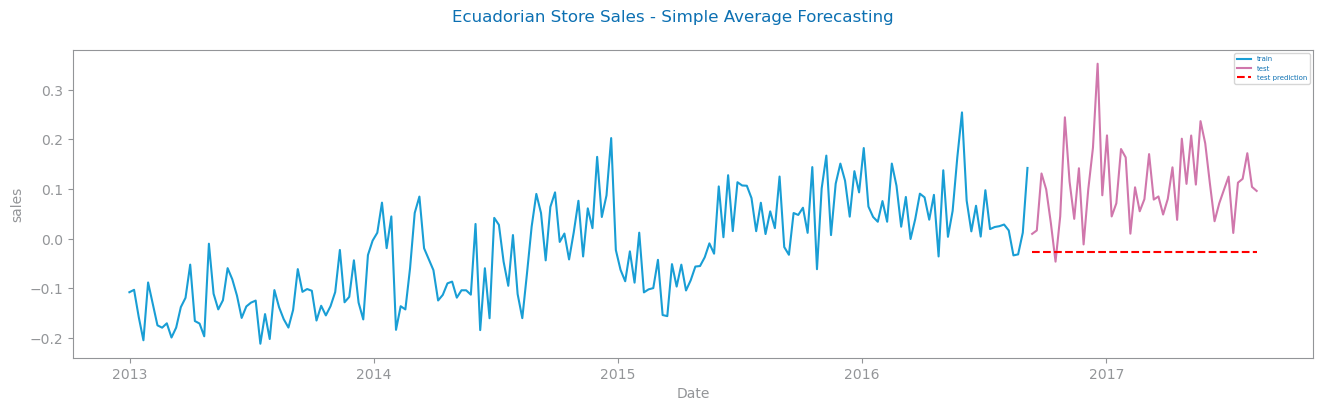

In [112]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Simple Average Forecasting",
    xlabel='Date',
    ylabel=target,
)

# Persistence Model

## Persistence Evaluate

In [113]:
from pandas import Series
from sklearn.base import RegressorMixin


class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

### Persistence Optimist

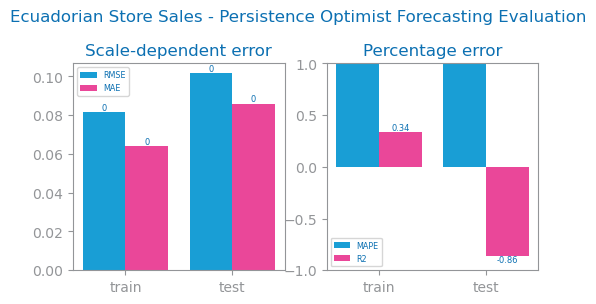

In [114]:

# Fit the Model
model = PersistenceOptimistRegressor()
model.fit(trnY)

# Predict the training and testing data
prd_trn = Series(model.predict(trnY), index=train.index)
prd_tst = Series(model.predict(tstY), index=test.index)

# Plot the forecasting evaluation
plot_forecasting_eval(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Persistence Optimist Forecasting Evaluation")
savefig(f"{file_tag}_persitence_optimist_evaluation.png")

### Persistence Optimist Plot

<Axes: xlabel='Date', ylabel='sales'>

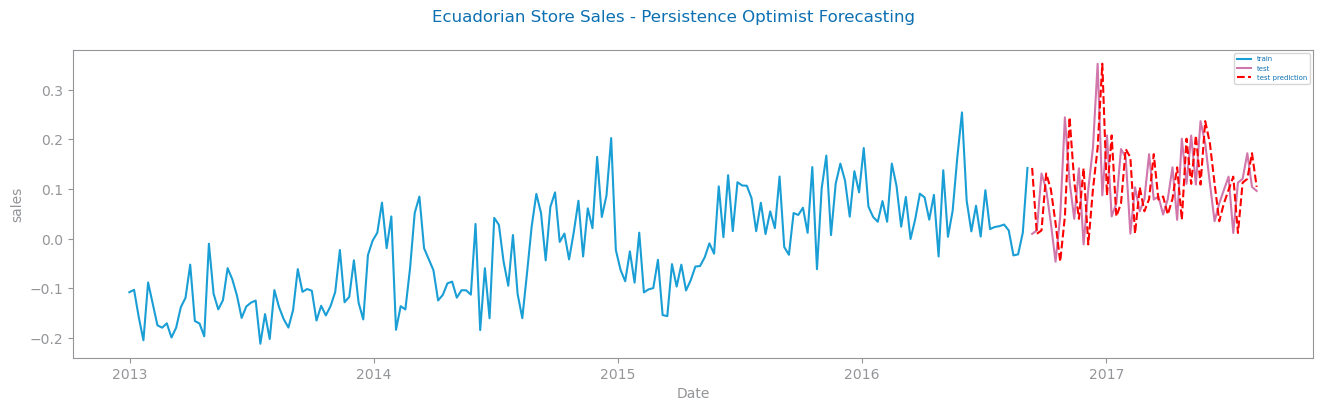

In [115]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Persistence Optimist Forecasting",
    xlabel='Date',
    ylabel=target,
)

### Persistence Realist

In [116]:
class PersistenceRealistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0
        self.estimations = [0]
        self.obs_len = 0

    def fit(self, X: Series):
        for i in range(1, len(X)):
            self.estimations.append(X.iloc[i - 1])
        self.obs_len = len(self.estimations)
        self.last = X.iloc[len(X) - 1]
        prd_series: Series = Series(self.estimations)
        prd_series.index = X.index
        return prd_series

    def predict(self, X: Series):
        prd: list = len(X) * [self.last]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

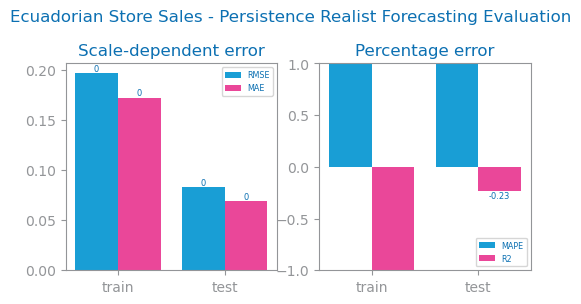

In [117]:

# Fit the Model
model = PersistenceRealistRegressor()
model.fit(trnY)

# Predict the training and testing data
prd_trn = Series(model.predict(trnY), index=train.index)
prd_tst = Series(model.predict(tstY), index=test.index)

# Plot the forecasting evaluation
plot_forecasting_eval(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Persistence Realist Forecasting Evaluation")
savefig(f"{file_tag}_persitence_realist_evaluation.png")

<Axes: xlabel='Date', ylabel='sales'>

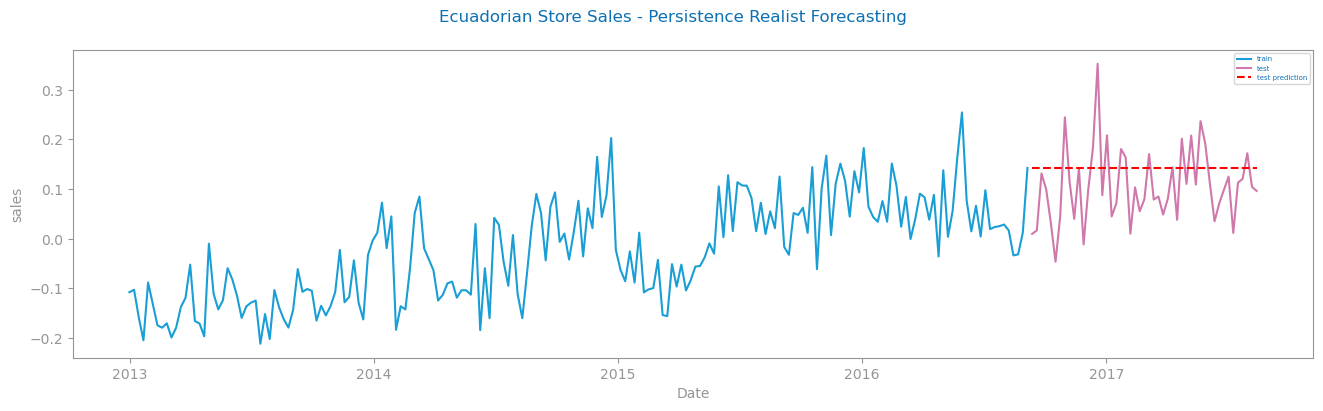

In [118]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Persistence Realist Forecasting",
    xlabel='Date',
    ylabel=target,
)

# Exponential Smoothing

### Exponential Smoothing Study

In [119]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


def exponential_smoothing_study(train: Series, test: Series, measure: str = "R2"):
    alpha_values = [i / 10 for i in range(1, 10)]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Exponential Smoothing", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for alpha in alpha_values:
        tool = SimpleExpSmoothing(train)
        model = tool.fit(smoothing_level=alpha, optimized=False)
        prd_tst = model.forecast(steps=len(test))

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (alpha,)
            best_model = model
        yvalues.append(eval)

    print(f"Exponential Smoothing best with alpha={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        alpha_values,
        yvalues,
        title=f"Exponential Smoothing Study - ({measure})",
        xlabel="alpha",
        ylabel=measure,
        percentage=flag,
    )

    return best_model, best_params

Exponential Smoothing best with alpha=1 -> R2=-0.007973450527352988
yvalues sample: [-0.6783245147797574, -0.8205659778715046, -0.6920912637024086, -0.462998356785874, -0.24399730091740102]
Types: [<class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-

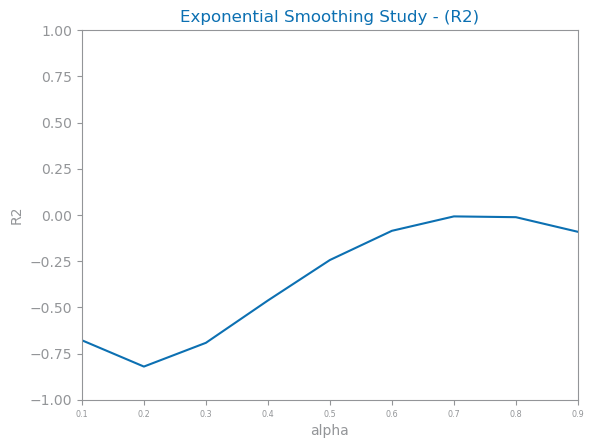

In [120]:
from matplotlib.pyplot import savefig

measure: str = "R2"


best_model, best_params = exponential_smoothing_study(trnY, tstY, measure=measure)
savefig(f"{file_tag}_exponential_smoothing_{measure}_study.png")

### Exponential Study Evaluate

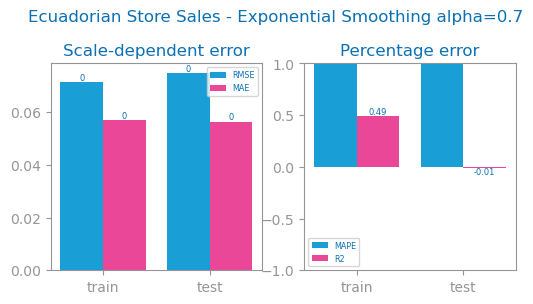

In [121]:
params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(trnY) - 1)
prd_tst = best_model.forecast(steps=len(tstY))

plot_forecasting_eval(trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Exponential Smoothing alpha={params[0]}")
savefig(f"{file_tag}_exponential_smoothing_{measure}_eval.png")

### Exponential Smoothing Forecast Plot

<Axes: xlabel='Date', ylabel='sales'>

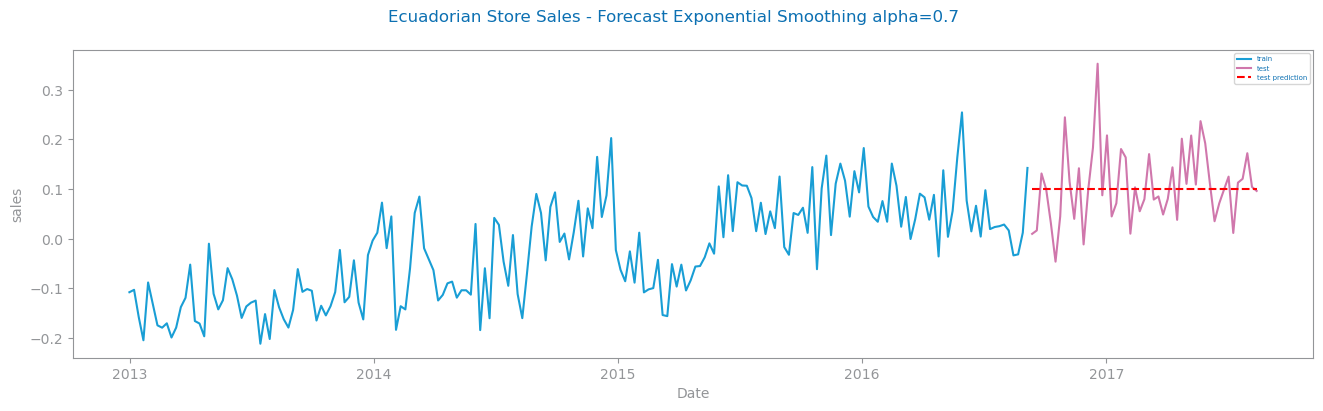

In [122]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Forecast Exponential Smoothing alpha={params[0]}",
    xlabel='Date',
    ylabel=target,
)

# Rolling Mean

In [123]:
from numpy import mean
from sklearn.base import RegressorMixin
import pandas as pd
from pandas import Series

class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size :]
        return

    def predict(self, X: Series):
        estimations = self.memory.tolist()

        # Loop through the series and predict the rolling mean
        for i in range(len(X)):
            new_value = mean(estimations[len(estimations) - self.win_size - i :])
            estimations.append(new_value)

        # Remove the first `win_size` values as they were used for initialization
        predictions = estimations[self.win_size:]

        # Ensure predictions are converted to a pandas Series with the correct index
        prd_series = pd.Series(predictions)

        # This explicitly assigns the index to match the length of the prediction array
        prd_series.index = X.index[:len(predictions)]  # Aligns the index with the predictions
        
        return prd_series


### Rolling Mean Study

NOT WORKING

Rolling Mean best with win=2 -> R2=-0.15315981780007215
yvalues sample: [-0.15315981780007215, -1.2705515796994673, -0.9704269533313767, -0.5314997577943466, -0.26079839614629363]
Types: [<class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>]


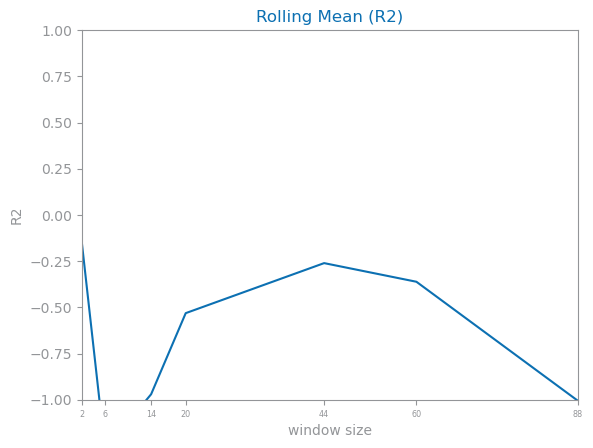

In [124]:
def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
    win_size = (2, 6, 14, 20, 44, 60, 88)  # Updated window sizes for daily data
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    train_series = pd.Series(train)
    test_series = pd.Series(test)
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train_series)
        prd_tst = pred.predict(test_series)
        prd_tst = prd_tst[:len(test_series)]  # Ensure the predicted series has the same length as the test series

        eval: float = FORECAST_MEASURES[measure](test_series, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params

best_model, best_params = rolling_mean_study(trnY, tstY)
savefig(f"{file_tag}_rollingmean_{measure}_study.png")

### Rolling Mean Evaluation

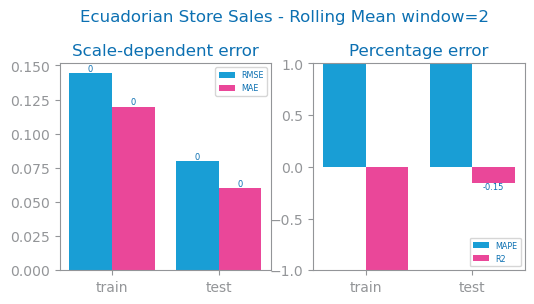

In [125]:
params = best_params["params"]
prd_trn = best_model.predict(pd.Series(trnY))  # Ensure pd.Series is passed
prd_tst = best_model.predict(pd.Series(tstY))  # Ensure pd.Series is passed

plot_forecasting_eval(trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean window={params[0]}")
savefig(f"{file_tag}_rolling_mean_{measure}_eval.png")

### Rolling Mean Plot Forecast

<Axes: xlabel='Date', ylabel='sales'>

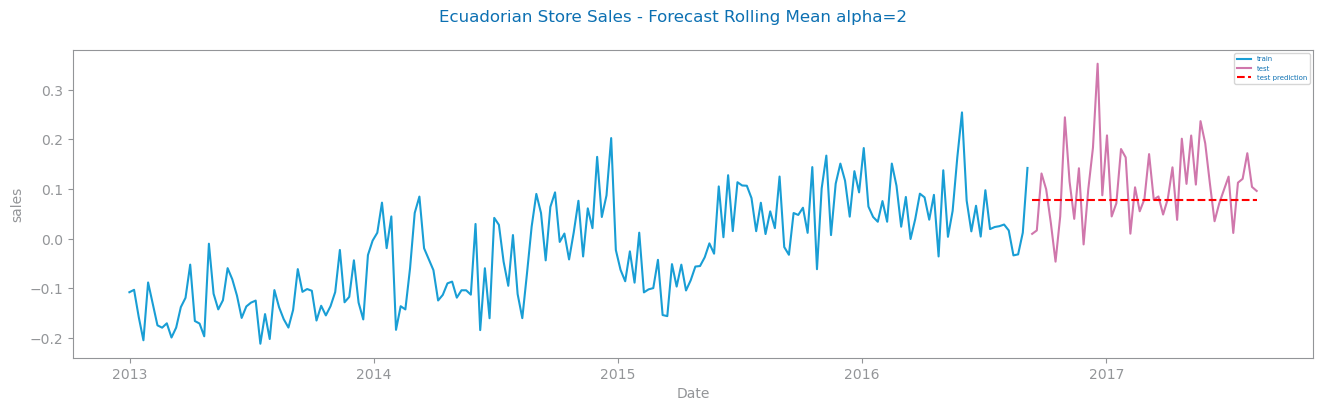

In [126]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Forecast Rolling Mean alpha={params[0]}",
    xlabel='Date',
    ylabel=target,
)

# Linear Regression

## Linear Regression Evaluate

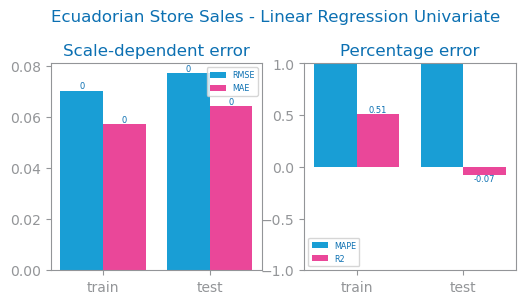

In [127]:
from pandas import Series
from dslabs_functions import plot_forecasting_eval
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare the training and testing data using the time index as the feature
trnX = arange(len(train)).reshape(-1, 1)
trnY = train[target].to_numpy()
tstX = arange(len(train), len(train+test)).reshape(-1, 1)
tstY = test[target].to_numpy()

# Fit the linear regression model
model_1 = LinearRegression()
model_1.fit(trnX, trnY)

# Predict the training and testing data
prd_trn = Series(model_1.predict(trnX), index=train.index)
prd_tst = Series(model_1.predict(tstX), index=test.index)


# Plot the forecasting evaluation
plot_forecasting_eval(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Linear Regression Univariate")
savefig(f"{file_tag}_linear_regression_univariate.png")

## Linear Regression Plot

<Axes: xlabel='Date', ylabel='sales'>

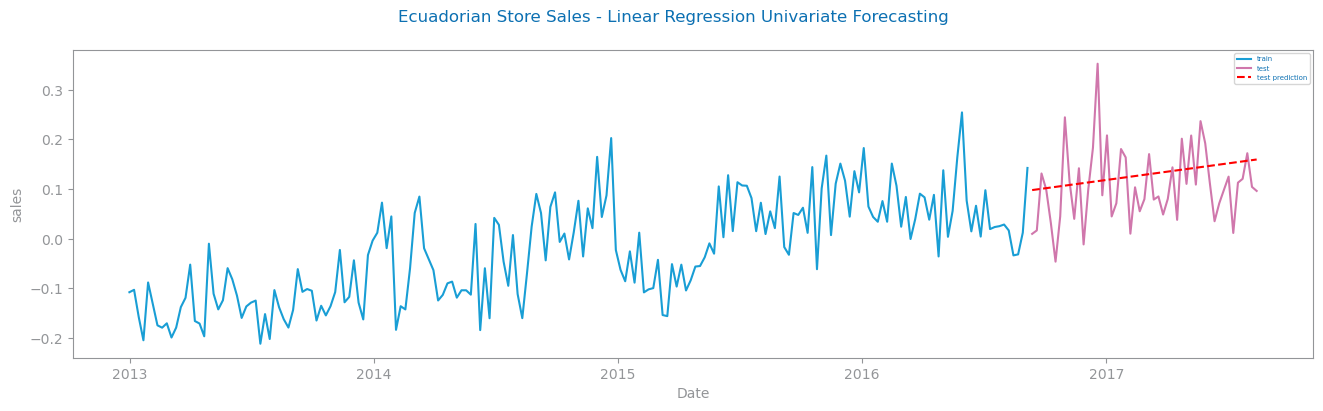

In [128]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Linear Regression Univariate Forecasting",
    xlabel='Date',
    ylabel=target,
)